In [1]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np
import os
import importlib.util
import huggingface_hub

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


/home/mila/s/sonia.joseph/env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
from vit_prisma.sae.sae import SparseAutoencoder
from vit_prisma.sae.evals import EvalConfig

from huggingface_hub import hf_hub_download

def download_sae_from_huggingface(repo_name, file_id, download_dir):
    os.makedirs(download_dir, exist_ok=True)
    local_path = hf_hub_download(repo_id=repo_name, filename=file_id, local_dir=download_dir)
    print(f"File downloaded successfully to: {local_path}")
    print(f"File size: {os.path.getsize(local_path)} bytes")
    

def download_sae():
    repo_name = 'Prisma-Multimodal/sae_weights'
    file_id = 'UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt'
    download_dir = '/network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out'
    download_sae_from_huggingface(repo_name, file_id, download_dir)

def load_sae():
    sae_path = '/network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out/UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt'
    cfg = EvalConfig()
    sae = SparseAutoencoder(cfg).load_from_pretrained_legacy_saelens_v2(sae_path)
    return sae

## only run this once
download_sae() 

sae = load_sae()
cfg = sae.cfg

File downloaded successfully to: /network/scratch/s/sonia.joseph/sae_checkpoints/tinyclip_40M_mlp_out/mustache_sae_16_mlp_out/UPDATED-final_sae_group_wkcn_TinyCLIP-ViT-40M-32-Text-19M-LAION400M_blocks.9.hook_mlp_out_8192.pt
File size: 33592403 bytes
n_tokens_per_buffer (millions): 0.032
Lower bound: n_contexts_per_buffer (millions): 0.00064
Total training steps: 15869
Total training images: 1300000
Total wandb updates: 158
Expansion factor: 16
n_tokens_per_feature_sampling_window (millions): 61.44
n_tokens_per_dead_feature_window (millions): 1024.0
Using Ghost Grads.
We will reset the sparsity calculation 52 times.
Number tokens in sparsity calculation window: 1.23e+06
Gradient clipping with max_norm=1.0
Using SAE initialization method: encoder_transpose_decoder
n_tokens_per_buffer (millions): 0.0512
Lower bound: n_contexts_per_buffer (millions): 0.001024
Total training steps: 15869
Total training images: 1300000
Total wandb updates: 158
Expansion factor: 16
n_tokens_per_feature_sampli

Image downloaded successfully.
Image size: (600, 460)
Image format: JPEG


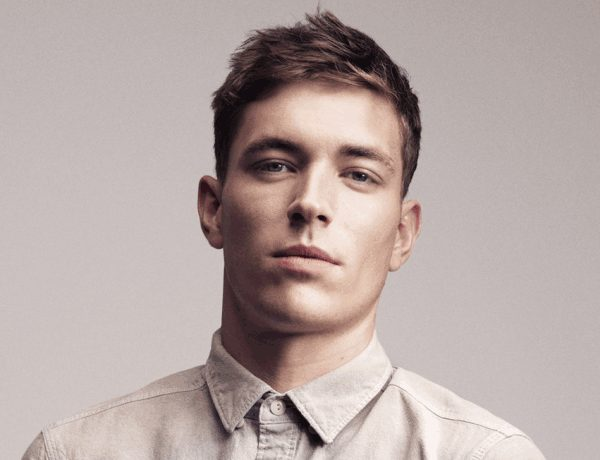

In [3]:
import requests
from PIL import Image
from io import BytesIO
def download_image_to_variable(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        print(f"Image downloaded successfully.")
        print(f"Image size: {image.size}")
        print(f"Image format: {image.format}")
        return image
    else:
        print(f"Failed to download image. Status code: {response.status_code}")
        return None

# Usage --> put your image here
url = "https://i0.wp.com/www.beard.org.in/wp-content/uploads/2016/11/10-Hairstyles-For-The-Clean-Shaven-Look-1-1.jpg?fit=600%2C460&ssl=1"
img = download_image_to_variable(url)
img

In [4]:
# get TinyCLIP embedding
from vit_prisma.models.base_vit import HookedViT


model = HookedViT.from_pretrained(cfg.model_name, is_timm=False, is_clip=True).to(cfg.device)


{'n_layers': 12, 'd_model': 512, 'd_head': 64, 'model_name': '', 'n_heads': 8, 'd_mlp': 2048, 'activation_name': 'gelu', 'eps': 1e-05, 'original_architecture': 'vit_clip_vision_encoder', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 512, 'n_params': None, 'layer_norm_pre': True, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M into HookedTransformer


In [5]:
# def embed_image(item):
#     return prior.interpolate([item], [1]).image_embeds[0]

# orig_emb = embed_image(img)
# print(orig_emb.shape)

In [6]:
from vit_prisma.dataloaders.imagenet_dataset import get_imagenet_transforms_clip

data_transform = get_imagenet_transforms_clip(cfg.model_name, cfg.image_size)
transformed_img = data_transform(img).to(cfg.device)


In [7]:
output_embed, cache = model.run_with_cache(transformed_img.unsqueeze(0))

In [8]:
output_embed.shape

torch.Size([1, 512])

In [11]:
from diffusers import StableUnCLIPImg2ImgPipeline
import torch

cache_dir = '/network/scratch/s/sonia.joseph/diffusion'

model_id = "stabilityai/stable-diffusion-2-1-unclip"
cache_dir = ...
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16, cache_dir=cache_dir)
pipe = pipe.to("cuda")

def generate_from_embedding(embedding, pipe):
    with torch.no_grad():
        image = pipe(image_embeds=embedding.unsqueeze(0), 
                     noise_level=20,  # Adjust as needed
                     guidance_scale=7.5).images[0]
    return image

TypeError: expected str, bytes or os.PathLike object, not ellipsis

In [40]:
def generate_from_embedding(embedding, pipe):
    # Skip the text encoder and use your embedding directly
    with torch.no_grad():
        latents = torch.randn((1, 4, 64, 64)).to("cuda")
        for t in pipe.scheduler.timesteps:
            noise_pred = pipe.unet(latents, t, encoder_hidden_states=embedding.unsqueeze(0))
            latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
    
    # Decode the latents to an image
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    return image

In [ ]:
generated_image = generate_from_embedding(your_embedding, pipe)